In [1]:
import numpy as np
import scipy 
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pylab as plt
import math
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

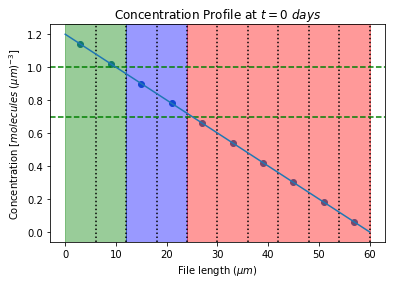

In [2]:
#At t == 0
n = 10 # number of cells 
k = 0.7 # time step
kg = 0.06 #proportionality constant
N = 2047 #discretization points


# initiation of cell lengths
L = np.zeros(n)

for i in range(n):
    L[i] = 6
    
tot = np.sum(L)
h = tot/(N+1) # space-step


# discretization of the file length

x = np.zeros(N+2)
x[0] = 0
x[N+1] = tot
for i in range(1,N+1):
    x[i]= x[i-1] + h
    
# 1) For each x we determine which L that point is in
    
y = list(x)

cells = []
step = 0

for j in range(len(L)):
    step += L[j]
    cell = []
    
    #p = 0
    for i in range(len(y)):

        if y[i] <= step:
           # p += y[i]
            cell.append(y[i])
    cells.append(cell)
    y = y[ len(cell): ]
    
############################################################################################################
# We compute the concerntration of each node at t = 0
U = np.zeros(N)
for i in range(N):
    #for j in range(N):
    U[i] = 1.2 - (1.2/tot)*x[i]


############################################################################################################
    
# 2) We compute the average concentration(C) for each L
# t=0    
conc = []
for i in range(len(cells)):
    A = 0
    for j in cells[i]:
        A += 1.2 - (1.2/tot)*j
    conc.append(A/len(cells[i]))
    

    
# We  do a backward finite difference scheme to compute concentration at the next time-step (t = 1)
tot = np.sum(L)
A = np.zeros((N,N))
h = tot/(N+1) # space-step
D = 200

w = (D*k)/(h**2)


b = np.zeros(N) 

v = np.zeros(N)
v[0] = 1.2*w


for i in range(N):
        #for j in range(N):
    b[i] = 1.2 - (1.2/tot)*x[i]

    
diag = np.zeros(N) + (1+2*w)
udiag = np.zeros(N) - w
ldiag = np.zeros(N) - w
A = scipy.sparse.dia_matrix(([diag, udiag, ldiag], [0, 1, -1]), shape=(N, N))

F = b+v 
    
    # Create dense matrix
    #A = lil_matrix(A)
A = csr_matrix(A)

    # Solving Matrices

C = np.zeros(N + 2)

U = spsolve(A,F)

    # Storing solutions
C[0] = 1.2
C[N+1]=0
for i in range(1,N + 1):
    C[i] = U[i-1]


####################################################################################################################    

# Compute average concentration at t = 1
concN = []
index = 0
for i in range(len(cells)):
    A = 0
    for j in range(index,index+len(cells[i])):
        A += C[j]
    index +=len(cells[i])
    concN.append(A/len(cells[i]))    

    
    
# 2b) We find midpoints of each cell (Which we can plot together with average concerntration at t = 0) 
    
mid_pt = []
for i in range(len(L)):
    summation = 0
    summation += sum(L[:i])
    mid = summation+(L[i]/2)
    mid_pt.append(mid)
    
#############################################################################################################
#Plotting
R1 = []
R2 = []
R3 = []
for i in range(len(L)):
    if conc[i] >= 1:
        R1.append(i)
    elif (conc[i] >= 0.7) and (conc[i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        
#a = T33(R1[-1])
#b = R2[-1]


T33 = []
A = 0
for i in range(len(L)):
    A += L[i]
    T33.append(A)
    
    
fig, ax = plt.subplots()
#ax.plot(range(20))
#ax.axvspan(8, 14, alpha=0.5, color='red')
ax.axvspan(0, T33[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T33[R1[-1]], T33[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T33[R2[-1]], T33[R3[-1]], alpha=0.4, color='red')
    

    

xcoords = T33
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')


plt.plot(x,C)
plt.scatter(mid_pt,conc)
plt.xlabel('File length ($\mu m$)')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration Profile at $t=0\,\, days$')
plt.show()



In [3]:
def Algorithm1(L, U, conc, concN, N = 2047):
# At t = 1
# 3) We find new lengths of L by solving equation 2 using backwards Euler 

    L1 = np.zeros(len(L))
    for i in range(len(L)):
        
        if conc[i] >= 0.7: 
            L1[i] = L[i] / (1 - k*kg*concN[i])
        else:
            L1[i] = L[i]
#################################################################################################################
# Splitting
    L2 = np.zeros(len(L))
    index = []
    half = []
    for i in range(len(L)):
        if (conc[i] >= 1) and (L1[i] >= 12):
            L2[i] = L1[i]/2
            index.append(i)
            half.append(L1[i]/2)
        else:
            L2[i] = L1[i]
    for i in range(len(index)):
        L2 = np.insert(L2, index[i]+(i+1),half[i])


#################################################################################################################    

    # section 4 and 5
    tot1 = np.sum(L2)
    A1 = np.zeros((N,N))
    h1 = tot1/(N+1) # space-step
    D = 200

    w1 = (D*k)/(h1**2)


    x1 = np.zeros(N+2)
    x1[0] = 0
    x1[N+1] = tot1
    for i in range(1,N+1):
        x1[i]= x1[i-1] + h1

    #b1 = np.zeros(N) # U at different fixed times

    v1 = np.zeros(N)
    v1[0] = 1.2*w1


    diag = np.zeros(N) + (1+2*w1)
    udiag = np.zeros(N) - w1
    ldiag = np.zeros(N) - w1
    A1 = scipy.sparse.dia_matrix(([diag, udiag, ldiag], [0, 1, -1]), shape=(N, N))

    F1 = U+v1 
    
    # Create dense matrix
    A1 = csr_matrix(A1)

    # Solving Matrices

    C1 = np.zeros(N + 2)

    U1 = spsolve(A1,F1)

    # Storing solutions
    C1[0] = 1.2
    C1[N+1]=0
    for i in range(1,N + 1):
        C1[i] = U1[i-1]
    #T1
    #plt.plot(x3,T3, label = 'Approximate solution')
    
###############################################################################################################

    F2 = U1+v1 

    C2 = np.zeros(N + 2)

    U2 = spsolve(A1,F2)

    # Storing solutions
    C2[0] = 1.2
    C2[N+1]=0
    for i in range(1,N + 1):
        C2[i] = U2[i-1]
    #T1
    #plt.plot(x3,T3, label = 'Approximate solution')

##############################################################################################################


    y1 = list(x1)

    cells1 = []
    step1 = 0

    for j in range(len(L2)):
        step1 += L2[j]
        cell1 = []

        #p = 0
        for i in range(len(y1)):

            if y1[i] <= step1:
               # p += y[i]
                cell1.append(y1[i])
        cells1.append(cell1)
        y1 = y1[ len(cell1): ]
        

    # Average Concentration
    conc1 = []
    index = 0
    for i in range(len(cells1)):
        A = 0
        for j in range(index,index+len(cells1[i])):
            A += C1[j]
        index +=len(cells1[i])
        conc1.append(A/len(cells1[i]))
##########################################################################################################
    # Average Concentration
    concN1 = []
    index = 0
    for i in range(len(cells1)):
        A = 0
        for j in range(index,index+len(cells1[i])):
            A += C2[j]
        index +=len(cells1[i])
        concN1.append(A/len(cells1[i]))
##########################################################################################################
        
    return  L2, U1, conc1, concN1, x1, C1

In [4]:
def run_time(n, init):
    '''
    Function to iterate Algorithm1 for n times
    '''
    inputt = init
    
    for i in range(n):
        output = Algorithm1(inputt[0], inputt[1], inputt[2], inputt[3])
        inputt = output
    return output

In [5]:
def Mid_pt(L):
    '''
    A function to calculate the midpoints of cells
    '''
    
    mid_pt = []
    for i in range(len(L)):
        summation = 0
        summation += sum(L[:i])
        mid = summation+(L[i]/2)
        mid_pt.append(mid)

    return mid_pt

In [26]:
def distance(n):
    '''
    Function to calculate the file length and the lengths of developmental zones
    '''
    
    F = run_time(n,(L, U, conc, concN))
    
    R1 = []
    R2 = []
    R3 = []
    for i in range(len(F[2])):
        if F[2][i] >= 1:
            R1.append(i)
        elif (F[2][i] >= 0.7) and (F[2][i] <= 1):
            R2.append(i)
        else:
            R3.append(i)


    F3 = []
    A = 0
    for i in range(len(F[0])):
        A += F[0][i]
        F3.append(A)
        
        
    D1 = F3[R1[-1]] - 0  #Length of division zone
    D2 = F3[R2[-1]] - F3[R1[-1]]  #Length of enlargement zone
    D3 = F3[R3[-1]] - F3[R2[-1]]  #Length of maturation+mature zone
    D4 = D1 + D2 + D3  # File Length
    
    return n, D1, D2, D3, D4


## A. Iteration $40$

In [7]:
T141 = run_time(40,(L, U, conc, concN) )

In [8]:
T142 = Mid_pt(T141[0])

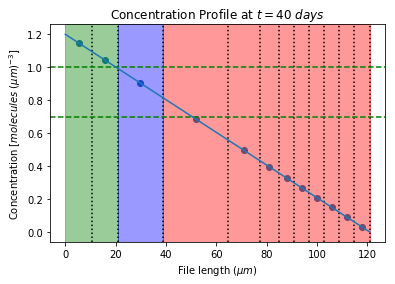

In [9]:
R1 = []
R2 = []
R3 = []
for i in range(len(T141[2])):
    if T141[2][i] >= 1:
        R1.append(i)
    elif (T141[2][i] >= 0.7) and (T141[2][i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        

T143 = []
A = 0
for i in range(len(T141[0])):
    A += T141[0][i]
    T143.append(A)
    
    
fig, ax = plt.subplots()
ax.axvspan(0, T143[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T143[R1[-1]], T143[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T143[R2[-1]], T143[R3[-1]], alpha=0.4, color='red')


xcoords = T143
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')


plt.plot(T141[4],T141[5])
plt.scatter(T142,T141[2])
plt.xlabel('File length ($\mu m$)')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration Profile at $t=40\,\, days$')
plt.show()

## Iteration $80$

In [10]:
T241 = run_time(80,(L, U, conc, concN) )

In [11]:
T242 = Mid_pt(T241[0])

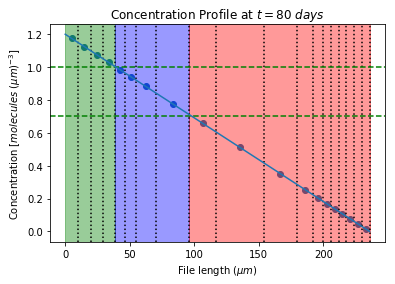

In [12]:
R1 = []
R2 = []
R3 = []
for i in range(len(T241[2])):
    if T241[2][i] >= 1:
        R1.append(i)
    elif (T241[2][i] >= 0.7) and (T241[2][i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        

T243 = []
A = 0
for i in range(len(T241[0])):
    A += T241[0][i]
    T243.append(A)
    
    
fig, ax = plt.subplots()
ax.axvspan(0, T243[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T243[R1[-1]], T243[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T243[R2[-1]], T243[R3[-1]], alpha=0.4, color='red')


xcoords = T243
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')


plt.plot(T241[4],T241[5])
plt.scatter(T242,T241[2])
plt.xlabel('File length ($\mu m$)')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration Profile at $t=80\,\, days$')
plt.show()

## Iteration $120$

In [13]:
T341 = run_time(120,(L, U, conc, concN) )

In [14]:
T342 = Mid_pt(T341[0])

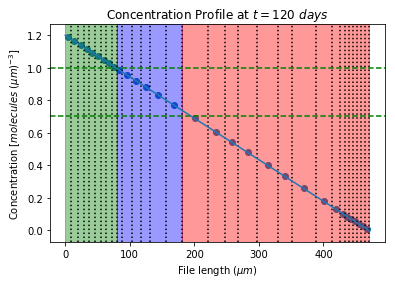

In [15]:
R1 = []
R2 = []
R3 = []
for i in range(len(T341[2])):
    if T341[2][i] >= 1:
        R1.append(i)
    elif (T341[2][i] >= 0.7) and (T341[2][i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        

T343 = []
A = 0
for i in range(len(T341[0])):
    A += T341[0][i]
    T343.append(A)
    
    
fig, ax = plt.subplots()
ax.axvspan(0, T343[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T343[R1[-1]], T343[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T343[R2[-1]], T343[R3[-1]], alpha=0.4, color='red')


xcoords = T343
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')


plt.plot(T341[4],T341[5])
plt.scatter(T342,T341[2])
plt.xlabel('File length ($\mu m$)')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration Profile at $t=120\,\, days$')
plt.show()

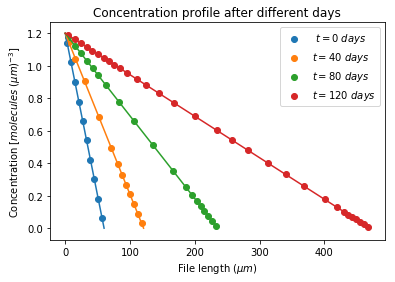

In [17]:
plt.scatter(mid_pt,conc, label = ' $t= 0 \,\,days$')
plt.plot(x,C)


plt.scatter(T142,T141[2], label = '$t= 40\,\,days$')
plt.plot(T141[4],T141[5])


plt.scatter(T242,T241[2], label = '$t= 80\,\,days$')
plt.plot(T241[4],T241[5])


plt.scatter(T342,T341[2], label = '$t= 120\,\,days$')
plt.plot(T341[4],T341[5])


plt.xlabel('File length ($\mu m$)')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration profile after different days')
plt.legend()
plt.show()

## Longer-Times

## t = 200

In [18]:
T2001 = run_time(200,(L, U, conc,concN) )

In [19]:
T2002 = Mid_pt(T2001[0])

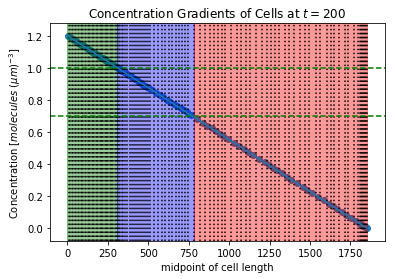

In [20]:
R1 = []
R2 = []
R3 = []
for i in range(len(T2001[2])):
    if T2001[2][i] >= 1:
        R1.append(i)
    elif (T2001[2][i] >= 0.7) and (T2001[2][i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        

T2003 = []
A = 0
for i in range(len(T2001[0])):
    A += T2001[0][i]
    T2003.append(A)
    
    
fig, ax = plt.subplots()
ax.axvspan(0, T2003[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T2003[R1[-1]], T2003[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T2003[R2[-1]], T2003[R3[-1]], alpha=0.4, color='red')


xcoords = T2003
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')

plt.plot(T2001[4],T2001[5])
plt.scatter(T2002,T2001[2])
plt.xlabel('midpoint of cell length')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration Gradients of Cells at $t=200$')
plt.show()

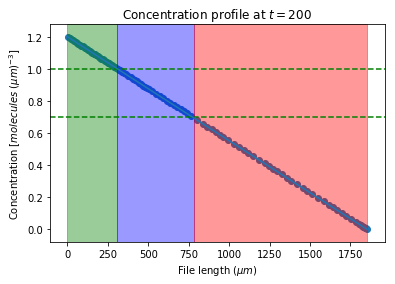

In [21]:
R1 = []
R2 = []
R3 = []
for i in range(len(T2001[2])):
    if T2001[2][i] >= 1:
        R1.append(i)
    elif (T2001[2][i] >= 0.7) and (T2001[2][i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        

T2003 = []
A = 0
for i in range(len(T2001[0])):
    A += T2001[0][i]
    T2003.append(A)
    
    
fig, ax = plt.subplots()
ax.axvspan(0, T2003[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T2003[R1[-1]], T2003[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T2003[R2[-1]], T2003[R3[-1]], alpha=0.4, color='red')


#xcoords = T2003
#for xc in xcoords:
    #plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')

plt.plot(T2001[4],T2001[5])
plt.scatter(T2002,T2001[2])
plt.xlabel('File length ($\mu m$)')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration profile at $t=200$')
plt.show()

## t = 250

In [22]:
T2501 = run_time(250,(L, U, conc,concN) )

In [23]:
T2502 = Mid_pt(T2501[0])

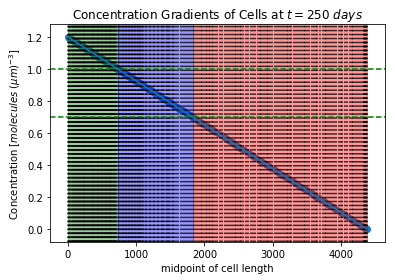

In [24]:
R1 = []
R2 = []
R3 = []
for i in range(len(T2501[2])):
    if T2501[2][i] >= 1:
        R1.append(i)
    elif (T2501[2][i] >= 0.7) and (T2501[2][i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        

T2503 = []
A = 0
for i in range(len(T2501[0])):
    A += T2501[0][i]
    T2503.append(A)
    
    
fig, ax = plt.subplots()
ax.axvspan(0, T2503[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T2503[R1[-1]], T2503[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T2503[R2[-1]], T2503[R3[-1]], alpha=0.4, color='red')


xcoords = T2503
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')

plt.plot(T2501[4],T2501[5])
plt.scatter(T2502,T2501[2])
plt.xlabel('midpoint of cell length')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration Gradients of Cells at $t=250 \,\, days$')
plt.show()

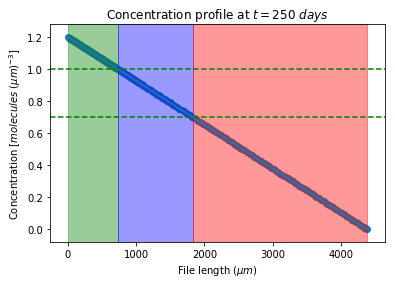

In [25]:
R1 = []
R2 = []
R3 = []
for i in range(len(T2501[2])):
    if T2501[2][i] >= 1:
        R1.append(i)
    elif (T2501[2][i] >= 0.7) and (T2501[2][i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        

T2503 = []
A = 0
for i in range(len(T2501[0])):
    A += T2501[0][i]
    T2503.append(A)
    
    
fig, ax = plt.subplots()
ax.axvspan(0, T2503[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T2503[R1[-1]], T2503[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T2503[R2[-1]], T2503[R3[-1]], alpha=0.4, color='red')


#xcoords = T2503
#for xc in xcoords:
    #plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')

plt.plot(T2501[4],T2501[5])
plt.scatter(T2502,T2501[2])
plt.xlabel('File length ($\mu m$)')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration profile at $t=250 \,\,days$')
plt.show()

## t = 300

In [32]:
T3001 = run_time(300,(L, U, conc,concN) )

In [33]:
T3002 = Mid_pt(T3001[0])

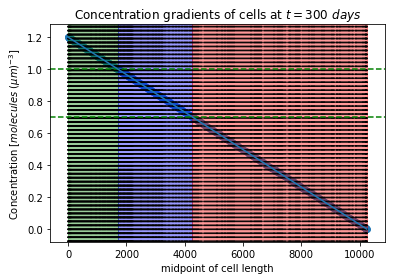

In [34]:
R1 = []
R2 = []
R3 = []
for i in range(len(T3001[2])):
    if T3001[2][i] >= 1:
        R1.append(i)
    elif (T3001[2][i] >= 0.7) and (T3001[2][i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        

T3003 = []
A = 0
for i in range(len(T3001[0])):
    A += T3001[0][i]
    T3003.append(A)
    
    
fig, ax = plt.subplots()
ax.axvspan(0, T3003[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T3003[R1[-1]], T3003[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T3003[R2[-1]], T3003[R3[-1]], alpha=0.4, color='red')


xcoords = T3003
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')

plt.plot(T3001[4],T3001[5])
plt.scatter(T3002,T3001[2])
plt.xlabel('midpoint of cell length')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration gradients of cells at $t=300\,\,days$')
plt.show()

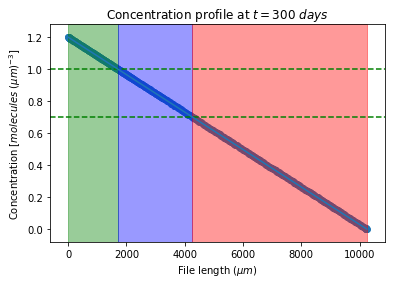

In [38]:
R1 = []
R2 = []
R3 = []
for i in range(len(T3001[2])):
    if T3001[2][i] >= 1:
        R1.append(i)
    elif (T3001[2][i] >= 0.7) and (T3001[2][i] <= 1):
        R2.append(i)
    else:
        R3.append(i)
        

T3003 = []
A = 0
for i in range(len(T3001[0])):
    A += T3001[0][i]
    T3003.append(A)
    
    
fig, ax = plt.subplots()
ax.axvspan(0, T3003[R1[-1]], alpha=0.4, color='green')
ax.axvspan(T3003[R1[-1]], T3003[R2[-1]], alpha=0.4, color='blue')
ax.axvspan(T3003[R2[-1]], T3003[R3[-1]], alpha=0.4, color='red')


#xcoords = T3003
#for xc in xcoords:
    #plt.axvline(x=xc, color='black', linestyle=':')
    
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0.7, color='g', linestyle='--')

plt.plot(T3001[4],T3001[5])
plt.scatter(T3002,T3001[2])
plt.xlabel('File length ($\mu m$)')
plt.ylabel('Concentration [$molecules\,\, (\mu m)^{-3}$]')
plt.title('Concentration profile at $t=300\,\,days$')
plt.show()

## We plot the file length as a function of time

In [18]:
N = 300
day = []
file = []
P = []
P.append(np.sum(L))

for i in range(N):
    day.append(i)
    
for i in range(1,N):
    P.append(np.sum(run_time(i,(L, U, conc, concN) )[0]))

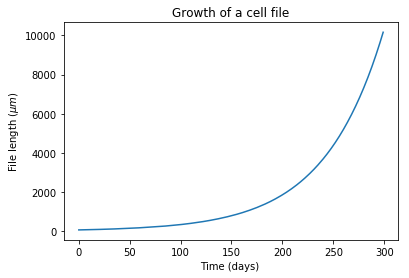

In [19]:
plt.xlabel('Time (days) ')
plt.ylabel('File length ($\mu m$)')
plt.title('Growth of a cell file')
plt.plot(day, P) 

In [27]:
distance(40)

(40,
 20.873144501790094,
 17.93014415213826,
 82.13539458168466,
 120.93868323561301)

In [28]:
distance(80)

(80,
 38.195949090372764,
 57.889312918747095,
 139.75721184442727,
 235.84247385354712)

In [29]:
distance(120)

(120,
 79.92029283513524,
 100.21991536249674,
 289.65346544480127,
 469.79367364243325)